In [1]:
#Define libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten
from sklearn.model_selection import KFold
from keras.utils import multi_gpu_model
#from sklearn.cross_validation import StratifiedKFold
from contextlib import redirect_stdout

from keras.utils import plot_model
from IPython.display import Image
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
import datetime
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint

gpu_options = tf.GPUOptions(allow_growth=True)
sess =tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
tf.keras.backend.set_session(sess)

NBname='_1000_15s_128-64_1'
%matplotlib inline

# =======
# 25_1s_12fPANet
# np.random.seed(100)
# kernel_len 25
# half (3,6, 9, 12, 15) 
# decay=0.0000125
# dropout 0.25
# # # diff b/w 441PANet2 & 10p121PANet2
# FC 2x12
# patience 10
# epochs 25
# lr=0.00003125
# =======

Using TensorFlow backend.


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

# font = {'family' : 'monospace',
#         'weight' : 'bold',
#         'size'   : 'larger'}

#plt.rc('font', **font)  # pass in the font dict as kwargs
plt.rc('font', size=MEDIUM_SIZE,family='normal',weight='normal')          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE,)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE,)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE,titleweight='bold')  # fontsize of the figure title
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15) 

In [3]:
print(str(datetime.datetime.now()))

2019-10-15 13:32:28.939821


In [4]:
def plot_perform0(mod, metric, last,ttl):
    #plt.figure(figsize=(13,13))
    plt.figure(figsize=(11,11))  
    for i in range(len(mod)):
        name=str(i+1)
        val = plt.plot(mod[i].epoch, mod[i].history['val_'+metric],
                           '--', label=name.title()+'_Val',linewidth=1.5)        
        plt.plot(mod[i].epoch, mod[i].history[metric],
                     color=val[0].get_color(), label=name.title()+'_Train',linewidth=1.2)

    plt.xlabel('Epochs')
    plt.ylabel(metric.replace('_',' ').title())
    plt.ylabel(metric.title())
    plt.title(ttl)
    plt.legend(loc='best')

    plt.xlim([0,max(mod[i].epoch)])
    figname=metric+last+'.png'
    plt.savefig(figname,dpi=500)


In [5]:
# def plot_perform1(mod, metric, last,ttl):
#     plt.figure(figsize=(11,11))  
#     name='final'        
#     plt.plot(mod.epoch, mod.history[metric], label=name.title()+'_Train',linewidth=1.5)
#     plt.xlabel('Epochs')
#     plt.ylabel(metric.replace('_',' ').title())
#     plt.ylabel(metric.title())
#     plt.title(ttl)
#     plt.legend(loc='best')

#     plt.xlim([0,max(mod.epoch)])
#     figname=metric+last+'.png'
#     plt.savefig(figname,dpi=500)


In [6]:
def create_model0(shape1):

    model0 = Sequential()

    model0.add(Conv1D(3, 1000, strides=2,padding='same',activation='relu', batch_input_shape=(None,shape1,1)))
    model0.add(BatchNormalization())
    model0.add(Conv1D(3, 1000, strides=1,padding='same',activation='relu'))
    model0.add(MaxPooling1D(2))
    
    model0.add(Conv1D(6, 1000, strides=2,padding='same',activation='relu'))
    model0.add(BatchNormalization())
    model0.add(Conv1D(6, 1000, strides=1,padding='same',activation='relu'))
    model0.add(MaxPooling1D(2))
    
    model0.add(Conv1D(9, 1000, strides=2,padding='same',activation='relu'))
    model0.add(BatchNormalization())
    model0.add(Conv1D(9, 1000, strides=1,padding='same',activation='relu'))
    model0.add(MaxPooling1D(2))

    model0.add(Conv1D(12, 1000, strides=2,padding='same',activation='relu'))
    model0.add(BatchNormalization())
    model0.add(Conv1D(12, 1000, strides=1,padding='same',activation='relu'))
    model0.add(MaxPooling1D(2))

    model0.add(Conv1D(15, 1000, strides=2,padding='same',activation='relu'))
    model0.add(BatchNormalization())
    model0.add(Conv1D(15, 1000, strides=1,padding='same',activation='relu'))
    model0.add(MaxPooling1D(2))

    model0.add(Flatten())
    model0.add(Dense(128, activation='relu'))
    model0.add(Dense(64, activation='relu'))
    #model0.add(Dense(8, activation='relu'))
    model0.add(Dropout(0.25))
    model0.add(Dense(2, activation='softmax'))

    return model0



In [7]:
%%time

batch_size = 10
N_epochs = 25
N_folds=4
np.random.seed(100)
kf = KFold(n_splits=N_folds, shuffle=False)

# fmd='train_x.npy'
# fld='train_y.npy'
# data=np.load(os.path.abspath(fmd))
# dlabels=np.load(os.path.abspath(fld))


rm='res_x.npy'
rl='res_y.npy'
rdata=np.load(os.path.abspath(rm))
rlabels=np.load(os.path.abspath(rl))

sm='sen_x.npy'
sl='sen_y.npy'
sdata=np.load(os.path.abspath(sm))
slabels=np.load(os.path.abspath(sl))

fmtim='testim_x.npy'
fltim='testim_y.npy'
testim=np.load(os.path.abspath(fmtim))
tlabelsim=np.load(os.path.abspath(fltim))

fmtb='testb_x.npy'
fltb='testb_y.npy'
testb=np.load(os.path.abspath(fmtb))
tlabelsb=np.load(os.path.abspath(fltb))



# =================
# Do once!
# =================
sen_batch = np.random.RandomState(seed=45).permutation(sdata.shape[0])
bins = np.linspace(0, 200, 41)
digitized = np.digitize(sen_batch, bins,right=False)
# ================


# # ===============================
# # # FINAL TRAIN
# # ===============================
# train_idx_k=np.random.permutation(rdata.shape[0])
# s_x=sdata[np.isin(digitized,train_idx_k+1)]
# s_y=slabels[np.isin(digitized,train_idx_k+1)]
# r_x=np.concatenate((rdata[train_idx_k],rdata[train_idx_k],rdata[train_idx_k],rdata[train_idx_k],rdata[train_idx_k]))
# r_y=np.concatenate((rlabels[train_idx_k],rlabels[train_idx_k],rlabels[train_idx_k],rlabels[train_idx_k],rlabels[train_idx_k]))

# f_train_x, f_train_y = np.concatenate((s_x,r_x)), np.concatenate((s_y,r_y)) 
# train_shuf_idx = np.random.permutation(f_train_x.shape[0])
# x_train, y_train = f_train_x[train_shuf_idx], f_train_y[train_shuf_idx]


# model0 = create_model0(rdata.shape[1])
# model0.compile(optimizer=keras.optimizers.Adamax(lr=0.00003125, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0000125),
#                              loss='categorical_crossentropy',
#                              metrics=['accuracy','categorical_crossentropy'])
# fmodel=model0.fit(x_train, y_train, epochs=N_epochs, batch_size=batch_size, verbose=2)
    
# =======================
# # ONLY FOR CROSS-VAL
# =======================

i=0
adamax=[]
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model'+NBname+'.h5', monitor='val_loss', save_best_only=True)]

for train_idx_k, val_idx_k in kf.split(rdata):
    print ("Running Fold", i+1, "/", N_folds)
    
    # ===============================
    # select train
    # ===============================
    
    s_train_x=sdata[np.isin(digitized,train_idx_k+1)]
    s_train_y=slabels[np.isin(digitized,train_idx_k+1)]
    r_train_x=np.concatenate((rdata[train_idx_k],rdata[train_idx_k],rdata[train_idx_k],rdata[train_idx_k],rdata[train_idx_k]))
    r_train_y=np.concatenate((rlabels[train_idx_k],rlabels[train_idx_k],rlabels[train_idx_k],rlabels[train_idx_k],rlabels[train_idx_k]))

    # ===============================
    # select val
    # ===============================
    
    s_val_x=sdata[np.isin(digitized,val_idx_k+1)]
    s_val_y=slabels[np.isin(digitized,val_idx_k+1)]
    
    r_val_x=np.concatenate((rdata[val_idx_k],rdata[val_idx_k],rdata[val_idx_k],rdata[val_idx_k],rdata[val_idx_k]))
    r_val_y=np.concatenate((rlabels[val_idx_k],rlabels[val_idx_k],rlabels[val_idx_k],rlabels[val_idx_k],rlabels[val_idx_k]))

    # ===============================
    # concatenate F_train/val_x/y
    # ===============================

    f_train_x, f_train_y = np.concatenate((s_train_x,r_train_x)), np.concatenate((s_train_y,r_train_y)) 
#     train_shuf_idx = np.random.permutation(f_train_x.shape[0])
#     F_train_x, F_train_y = f_train_x[train_shuf_idx], f_train_y[train_shuf_idx]

    f_val_x, f_val_y = np.concatenate((s_val_x,r_val_x)), np.concatenate((s_val_y,r_val_y))
#     val_shuf_idx = np.random.permutation(f_val_x.shape[0])
#     F_val_x, F_val_y = f_val_x[val_shuf_idx], f_val_y[val_shuf_idx]

    # ===============================
    # shuffle just because we can?
    # ===============================
    
    train_shuf_idx = np.random.permutation(f_train_x.shape[0])
    x_train_CV, y_train_CV = f_train_x[train_shuf_idx], f_train_y[train_shuf_idx]
    
    val_shuf_idx = np.random.permutation(f_val_x.shape[0])
    x_val_CV, y_val_CV = f_val_x[val_shuf_idx], f_val_y[val_shuf_idx] 

    # ===============================
    # clear and create empty model 
    # ===============================
    
    model0 = None # Clearing the NN.    
    model0 = create_model0(rdata.shape[1])
    
#    x_train_CV, y_train_CV, = data[train_idx_k], dlabels[train_idx_k]
#    x_val_CV, y_val_CV, = data[val_idx_k], dlabels[val_idx_k]

#     parallel_model = None    
#     parallel_model = multi_gpu_model(model0, gpus=2)
#     #default
#     #parallel_model.compile(optimizer=keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
#     parallel_model.compile(optimizer=keras.optimizers.Adamax(lr=0.004, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.005),
#                              loss='categorical_crossentropy',
#                              metrics=['accuracy','categorical_crossentropy'])
#     model0_adamax = parallel_model.fit(x_train_CV, y_train_CV,
#                                           epochs=N_epochs,
#                                           batch_size=batch_size, 
#                                           validation_data=(x_val_CV,y_val_CV),
#                                           verbose=1)

    #default
    #parallel_model.compile(optimizer=keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
    model0.compile(optimizer=keras.optimizers.Adamax(lr=0.00000625, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0000125),
                             loss='categorical_crossentropy',
                             metrics=['accuracy','categorical_crossentropy'])
    model0_adamax = model0.fit(x_train_CV, y_train_CV,
                                          epochs=N_epochs,
                                          batch_size=batch_size, 
                                          validation_data=(x_val_CV,y_val_CV),
                                          verbose=2,callbacks=callbacks)

    adamax.append(model0_adamax)           
    i=i+1

Running Fold 1 / 4
Train on 300 samples, validate on 100 samples
Epoch 1/25
 - 136s - loss: 0.5841 - acc: 0.7067 - categorical_crossentropy: 0.5841 - val_loss: 0.6391 - val_acc: 0.6600 - val_categorical_crossentropy: 0.6391
Epoch 2/25
 - 88s - loss: 0.2807 - acc: 0.9267 - categorical_crossentropy: 0.2807 - val_loss: 0.5990 - val_acc: 0.6300 - val_categorical_crossentropy: 0.5990
Epoch 3/25
 - 89s - loss: 0.1617 - acc: 0.9767 - categorical_crossentropy: 0.1617 - val_loss: 0.6437 - val_acc: 0.6200 - val_categorical_crossentropy: 0.6437
Epoch 4/25
 - 88s - loss: 0.1125 - acc: 0.9900 - categorical_crossentropy: 0.1125 - val_loss: 0.7165 - val_acc: 0.6400 - val_categorical_crossentropy: 0.7165
Epoch 5/25
 - 88s - loss: 0.0781 - acc: 0.9933 - categorical_crossentropy: 0.0781 - val_loss: 0.7144 - val_acc: 0.6300 - val_categorical_crossentropy: 0.7144
Epoch 6/25
 - 88s - loss: 0.0594 - acc: 0.9967 - categorical_crossentropy: 0.0594 - val_loss: 0.7416 - val_acc: 0.6400 - val_categorical_crossen

In [8]:
# from keras.models import load_model
# fmodel= load_model('final_12fPANet.h5')


/home/uu_bio_amrdl/dprasad/miniconda3/envs/TFgpu/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


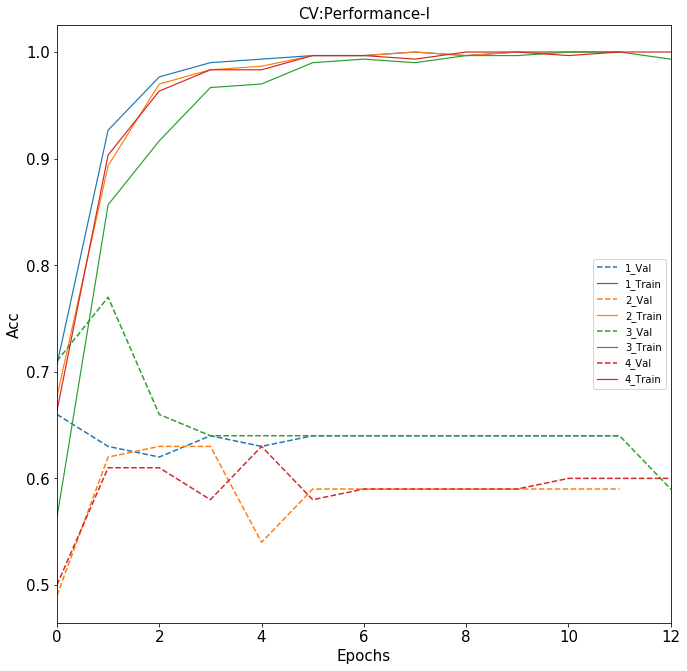

In [9]:
# commented, works after finishing training
plot_perform0(adamax,'acc',NBname,'CV:Performance-I')

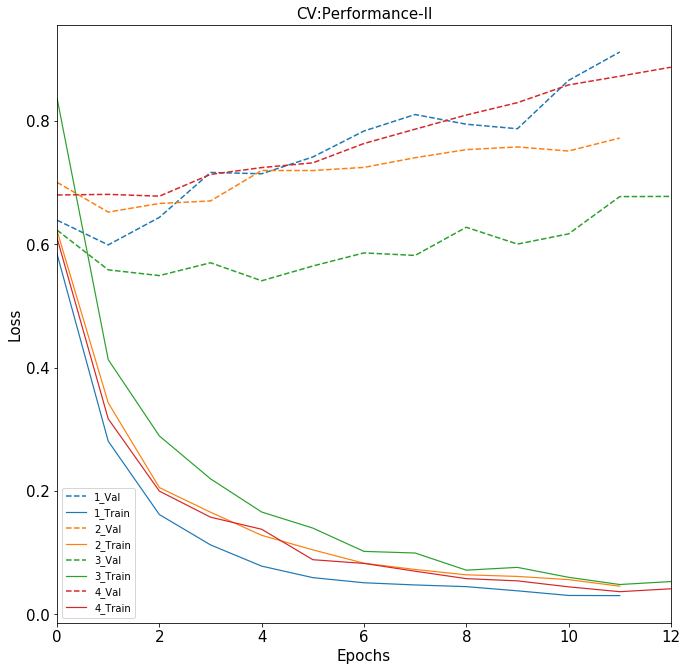

In [10]:
# commented, works after finishing training
plot_perform0(adamax,'loss',NBname,'CV:Performance-II')

In [11]:
with open('summary'+NBname+'.txt', 'w') as f:
    with redirect_stdout(f):
        model0.summary()

In [12]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 576006, 3)         3003      
_________________________________________________________________
batch_normalization_16 (Batc (None, 576006, 3)         12        
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 576006, 3)         9003      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 288003, 3)         0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 144002, 6)         18006     
_________________________________________________________________
batch_normalization_17 (Batc (None, 144002, 6)         24        
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 144002, 6)         36006     
__________

In [13]:
print(str(datetime.datetime.now()))

2019-10-15 14:50:25.395993


In [14]:
# # ==========================================================================
# # # DO NOT UNCOMMENT UNTIL THE END; DECLARES FUNCTION FOR AN UNBIASED TEST
# # ==========================================================================

# def plot_auc(aucies,fprs,tprs, last):
#   #plt.figure(figsize=(13,13))
#     plt.figure(figsize=(11,11))
#     plt.plot([0, 1], [0, 1], 'k--')  
#     for i in range(len(aucies)):
#         st='CV_'+str(i+1)+' '
#         if i==0:
#             st='Balanced'
#         else:
#             st='Imbalanced'
#         plt.plot(fprs[i], tprs[i], label='{} (AUC= {:.3f})'.format(st,aucies[i]),linewidth=1.5)

#         plt.xlabel('False positive rate')
#         plt.ylabel('True positive rate')
#         plt.title('ROC curve: PANet')
#         plt.legend(loc='best')
    
#         figname='ROC'+last+'.png'
#         plt.savefig(figname,dpi=500)


In [15]:
# # ==========================================================================
# # # THIS IS THE TEST; DO NOT UNCOMMENT UNTIL THE END
# # ==========================================================================
    
# fpr_x=[]
# tpr_x=[]
# thresholds_x=[]
# auc_x=[]

# pre_S=[]
# rec_S=[]
# f1_S=[]
# kap_S=[]
# acc_S=[]
# mat_S=[]


# BALANCED TESTING

In [16]:
# NBname='_F-12fPANetb'
# y_predb = fmodel.model.predict(testb)#.ravel()
# fpr_0, tpr_0, thresholds_0 = roc_curve(tlabelsb[:,1], y_predb[:,1])
# fpr_x.append(fpr_0)
# tpr_x.append(tpr_0)
# thresholds_x.append(thresholds_0)    
# auc_x.append(auc(fpr_0, tpr_0))     
    
# # predict probabilities for testb set
# yhat_probs = fmodel.model.predict(testb, verbose=0)
# # predict crisp classes for testb set
# yhat_classes = fmodel.model.predict_classes(testb, verbose=0)
# # reduce to 1d array
# testby=tlabelsb[:,1]

# # yhat_probs = yhat_probs[:, 1]
# # #yhat_classes = yhat_classes[:, 0]

# # accuracy: (tp + tn) / (p + n)
# acc_S.append(accuracy_score(testby, yhat_classes))
# #print('Accuracy: %f' % accuracy_score(testby, yhat_classes))

# #precision tp / (tp + fp)
# pre_S.append(precision_score(testby, yhat_classes))
# #print('Precision: %f' % precision_score(testby, yhat_classes))

# #recall: tp / (tp + fn)
# rec_S.append(recall_score(testby, yhat_classes))
# #print('Recall: %f' % recall_score(testby, yhat_classes))

# # f1: 2 tp / (2 tp + fp + fn)
# f1_S.append(f1_score(testby, yhat_classes))
# #print('F1 score: %f' % f1_score(testby, yhat_classes))

# # kappa
# kap_S.append(cohen_kappa_score(testby, yhat_classes))
# #print('Cohens kappa: %f' % cohen_kappa_score(testby, yhat_classes))

# # confusion matrix
# mat_S.append(confusion_matrix(testby, yhat_classes))
# #print(confusion_matrix(testby, yhat_classes))

# with open('perform'+NBname+'.txt', "w") as f:
#     f.writelines("AUC \t Accuracy \t Precision \t Recall \t F1 \t Kappa\n")
#     f.writelines(map("{}\t{}\t{}\t{}\t{}\t{}\n".format, auc_x, acc_S, pre_S, rec_S, f1_S, kap_S))
#     for x in range(len(fpr_x)):
#         f.writelines(map("{}\n".format, mat_S[x]))
#         f.writelines(map("{}\t{}\t{}\n".format, fpr_x[x], tpr_x[x], thresholds_x[x]))
    
# # ==========================================================================
# # # THIS IS THE BALANCED testb; DO NOT UNCOMMENT UNTIL THE END
# # ==========================================================================

# plot_auc(auc_x,fpr_x,tpr_x,NBname)

## to see which samples were correctly classified ...

In [17]:
# yhat_probs[yhat_probs[:,1]>=0.5,1]

In [18]:
# yhat_probs[:,1]>=0.5

In [19]:
# yhat_classes

In [20]:
# testby

# IMBALANCED TESTING

In [21]:
# NBname='_F-12fPANetim'
# y_pred = fmodel.model.predict(testim)#.ravel()
# fpr_0, tpr_0, thresholds_0 = roc_curve(tlabelsim[:,1], y_pred[:,1])
# fpr_x.append(fpr_0)
# tpr_x.append(tpr_0)
# thresholds_x.append(thresholds_0)    
# auc_x.append(auc(fpr_0, tpr_0))     
    
# # predict probabilities for testim set
# yhat_probs = fmodel.model.predict(testim, verbose=0)
# # predict crisp classes for testim set
# yhat_classes = fmodel.model.predict_classes(testim, verbose=0)
# # reduce to 1d array
# testimy=tlabelsim[:,1]

# #yhat_probs = yhat_probs[:, 0]
# #yhat_classes = yhat_classes[:, 0]

# # accuracy: (tp + tn) / (p + n)
# acc_S.append(accuracy_score(testimy, yhat_classes))
# #print('Accuracy: %f' % accuracy_score(testimy, yhat_classes))

# #precision tp / (tp + fp)
# pre_S.append(precision_score(testimy, yhat_classes))
# #print('Precision: %f' % precision_score(testimy, yhat_classes))

# #recall: tp / (tp + fn)
# rec_S.append(recall_score(testimy, yhat_classes))
# #print('Recall: %f' % recall_score(testimy, yhat_classes))

# # f1: 2 tp / (2 tp + fp + fn)
# f1_S.append(f1_score(testimy, yhat_classes))
# #print('F1 score: %f' % f1_score(testimy, yhat_classes))

# # kappa
# kap_S.append(cohen_kappa_score(testimy, yhat_classes))
# #print('Cohens kappa: %f' % cohen_kappa_score(testimy, yhat_classes))

# # confusion matrix
# mat_S.append(confusion_matrix(testimy, yhat_classes))
# #print(confusion_matrix(testimy, yhat_classes))

# with open('perform'+NBname+'.txt', "w") as f:
#     f.writelines("##THE TWO LINES ARE FOR BALANCED AND IMBALALANCED TEST\n")
#     f.writelines("#AUC \t Accuracy \t Precision \t Recall \t F1 \t Kappa\n")
#     f.writelines(map("{}\t{}\t{}\t{}\t{}\t{}\n".format, auc_x, acc_S, pre_S, rec_S, f1_S, kap_S))
#     f.writelines("#TRUE_SENSITIVE \t TRUE_RESISTANT\n")
#     for x in range(len(fpr_x)):
#         f.writelines(map("{}\n".format, mat_S[x]))
#         #f.writelines(map("{}\t{}\t{}\n".format, fpr_x[x], tpr_x[x], thresholds_x[x]))
#     f.writelines("#FPR \t TPR \t THRESHOLDs\n")
#     for x in range(len(fpr_x)):
#         #f.writelines(map("{}\n".format, mat_S[x]))
#         f.writelines(map("{}\t{}\t{}\n".format, fpr_x[x], tpr_x[x], thresholds_x[x]))
#         f.writelines("#NEXT\n")
# # ==========================================================================
# # # THIS IS THE UNBIASED testim; DO NOT UNCOMMENT UNTIL THE END
# # ==========================================================================

# plot_auc(auc_x,fpr_x,tpr_x,NBname)

## to see which samples were correctly classified ...

In [22]:
# yhat_probs[yhat_probs[:,1]>=0.5,1]

In [23]:
# yhat_probs[:,1]>=0.5

In [24]:
# yhat_classes

In [25]:
# testimy

# MISCELLANEOUS

In [26]:
# mat_S #confusion matrix

In [27]:
# auc_x #AUC balanced, imabalanced

In [28]:
# produces extremely tall png, that doesn't really fit into a screen
# plot_model(model0, to_file='model'+NBname+'.png', show_shapes=True,show_layer_names=False)

In [29]:
# produces SVG object. dont uncomment until desperate
# SVG(model_to_dot(model0, show_shapes=True,show_layer_names=False).create(prog='dot', format='svg'))

# END OF TESTING

In [30]:
print(str(datetime.datetime.now()))

2019-10-15 14:50:38.593835


In [31]:
# # =================================
# # Legacy codes
# # =================================

# # sdata.shape
# # (200, 1152012, 1)
# print('\n')
# sen_batch = np.random.RandomState(seed=45).permutation(sdata.shape[0])
# print(sen_batch)

# print('\n')
# bins = np.linspace(0, 200, 41)
# print(bins.shape)
# print(bins)

# print('\n')
# digitized = np.digitize(sen_batch, bins,right=False)
# print(digitized.shape)
# print(digitized)

# # #instead of 10, run counter
# # print(np.where(digitized==10))
# # print(sdata[np.where(digitized==10)].shape)
# # # (array([  0,  96, 101, 159, 183]),)
# # # (5, 1152012, 1)

# # dig_sort=digitized
# # dig_sort.sort()
# # # print(dig_sort)
# # # [ 1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4  5  5  5  5
# # #   5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9 10 10 10
# # #  10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14 15 15
# # #  15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19 20
# # #  20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23 24 24 24 24 24
# # #  25 25 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28 28 29 29 29 29
# # #  29 30 30 30 30 30 31 31 31 31 31 32 32 32 32 32 33 33 33 33 33 34 34 34
# # #  34 34 35 35 35 35 35 36 36 36 36 36 37 37 37 37 37 38 38 38 38 38 39 39
# # #  39 39 39 40 40 40 40 40]
# # print(val_idx_k)
# # # array([ 2,  3,  8, 10, 14, 15, 23, 24, 30, 32])
# # print(val_idx_k+1)
# # # array([ 3,  4,  9, 11, 15, 16, 24, 25, 31, 33])
# # print('\n')
# # print(sdata[np.isin(digitized,train_idx_k+1)].shape)
# # # (150, 1152012, 1)
# # print(sdata[np.isin(digitized,val_idx_k+1)].shape)
# # # (50, 1152012, 1)
